# Exploring BPZ Test Data

_Alex Malz (NYU) & Phil Marshall (SLAC)_

In this notebook we develop machinery to evaluate our approximations on whole datasets in "survey mode." 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
    
import hickle
import numpy as np
from pathos.multiprocessing import ProcessingPool as Pool
import random
import cProfile
import pstats
import StringIO
import timeit
import psutil
import sys
import timeit

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

import qp
from qp.utils import calculate_kl_divergence as make_kld

np.random.seed = 42
random.seed = 42

## Set-up, Ingest

There are two datasets available:

* $10^{5}$ LSST-like mock data provided by Sam Schmidt (UC Davis, LSST
* $10^{4}$ Euclid-like mock data provided by Melissa Graham (UW, LSST)

In [3]:
# choose one of these:
dataset_key = 'Euclid'# Melissa Graham's data
# dataset_key = 'LSST'# Sam Schmidt's data
dataname = dataset_key

dataset_info = {}

dataset_info[dataset_key] = {}

Both datasets are fit with BPZ.

In [4]:
if dataset_key == 'Euclid':
    datafilename = 'bpz_euclid_test_10_2.probs'
elif dataset_key == 'LSST':
    datafilename = 'test_magscat_trainingfile_probs.out'
    
dataset_info[dataset_key]['filename'] = datafilename

The data files don't appear to come with information about the native format or metaparameters, but we are told they're evaluations on a regular grid of redshifts with given endpoints and number of parameters.

In [5]:
if dataset_key == 'Euclid':
    z_low = 0.01
    z_high = 3.51
elif dataset_key == 'LSST':
    z_low = 0.005
    z_high = 2.11
    
dataset_info[dataset_key]['z_lim'] = (z_low, z_high)

z_grid = np.arange(z_low, z_high, 0.01, dtype='float')
z_range = z_high - z_low
delta_z = z_range / len(z_grid)

dataset_info[dataset_key]['z_grid'] = z_grid
dataset_info[dataset_key]['delta_z'] = delta_z

Let's read in the catalog data.  Note that it has a sizeable footprint even for a "small" number of galaxies.

In [6]:
## Warning: reading in the data is slow for Sam Schmidt's dataset!
with open(dataset_info[dataset_key]['filename'], 'rb') as data_file:
    lines = (line.split(None) for line in data_file)
    lines.next()
    pdfs = np.array([[float(line[k]) for k in range(1,len(line))] for line in lines])

# dataset_info[dataset_key]['native_pdfs'] = pdfs

print('storage footprint '+str(sys.getsizeof(pdfs))+' bytes')

storage footprint 84000112 bytes


## Visualizing the BPZ $p(z)$'s

Let's plot a few interesting PDFs from the dataset.

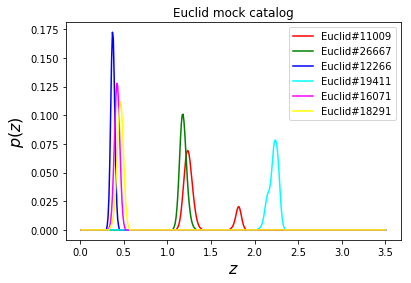

In [7]:
colors = ['red','green','blue','cyan','magenta','yellow']
n_plot = len(colors)

# if dataset_key == 'mg':
#     indices = [1, 3, 14, 16, 19, 21]
# elif dataset_key == 'ss':
n_gals_tot = len(pdfs)
full_gal_range = range(n_gals_tot)
indices = np.random.choice(full_gal_range, n_plot)

for i in range(n_plot):
    plt.plot(dataset_info[dataset_key]['z_grid'], pdfs[indices[i]], 
             color=colors[i], label=dataset_key+'#'+str(indices[i]))
plt.xlabel(r'$z$', fontsize=16)
plt.ylabel(r'$p(z)$', fontsize=16)
plt.title(dataset_key+' mock catalog')
plt.legend()
plt.savefig('pz_placeholder_'+dataset_key+'.png', dpi=250)

Note: BPZ PDFs are not properly normalized. In order to be true PDFs, we want $\int_{-\infty}^{\infty} p(z) dz = 1$, but the data file entries satisfy $\sum _{z=z_min}^{z_{max}} p(z) = 1$, which is not in general the same.  `qp` approximates the desired integral as $1 = \int p(z) dz \approx \Delta_{z} \sum_{z=z_{min}}^{z_{max}} p(z)$ where $\Delta_{z} = \frac{z_{max} - z_{min}}{N_{ff}}$, where the native format PDF is evaluated at $N_{ff}$ redshifts.

## Approximating the BPZ $p(z)'s$

Let's pick out a galaxy with an interesting $p(z)$ to turn into a `qp.PDF` object initialized with a gridded parametrization.

Plotted gridded.


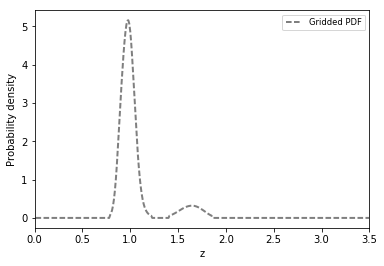

In [8]:
if dataset_key == 'Euclid':
    chosen = 1
elif dataset_key == 'LSST':
    chosen = 108019

G = qp.PDF(gridded=(dataset_info[dataset_key]['z_grid'], pdfs[chosen]))
G.plot()

`qp` cannot currently convert gridded PDFs to histograms or quantiles - we need to make a GMM first, and use this to instantiate a `qp.PDF` object using a `qp.composite` object based on that GMM as `qp.PDF.truth`.  The number of parameters necessary for a qualitatively good fit depends on the characteristics of the dataset. 

In [9]:
if dataset_key == 'Euclid':
    nc_needed = 3
elif datanset_key == 'LSST':
    nc_needed = 5
    
dataset_info[dataset_key]['N_GMM'] = nc_needed

We can fit a GMM directly to the gridded PDF (via an internal interpolation).  The direct fit, however, is not guaranteed to converge, particularly if the underlying distribution is not actually well-described by a weighted sum of Gaussians -- this is why storing the GMM parameters instead of a non-parametric format can be dangerous.

(array([  9.50296130e-02,   9.13478664e-01,   6.00090910e-14]), array([ 1.63821369,  0.97362529,  0.01000003]), array([ 0.11477798,  0.07009695,  0.01011561]))
0.0950296130204$\cdot\mathcal{N}($1.63821369069,0.114777982467)\n0.913478664431$\cdot\mathcal{N}($0.973625286165,0.0700969523659)\n6.00090910438e-14$\cdot\mathcal{N}($0.010000025646,0.0101156124227)\n
2.02563095093 for GMM fit to gridded
Plotted mixture model.
Plotted gridded.


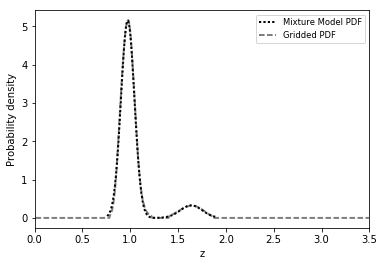

In [10]:
start_time = timeit.default_timer()
G.mix_mod_fit(n_components=dataset_info[dataset_key]['N_GMM'], 
              using='gridded', vb=True)
time = timeit.default_timer() - start_time
print(str(time)+' for GMM fit to gridded')

G.plot()

The alternative is to take a large number of samples and fit a GMM to those (via the same internal interpolation).  We can check that the fits are very similar.  Though it is slower, we will sample before fitting to guarantee convergence.

(array([ 0.4637791 ,  0.09401068,  0.44221022]), array([ 0.93888452,  1.6484699 ,  1.02192405]), array([ 0.05286632,  0.10301359,  0.06002561]))
0.463779098702$\cdot\mathcal{N}($0.938884519493,0.0528663218644)\n0.0940106825553$\cdot\mathcal{N}($1.64846989606,0.103013587563)\n0.442210218743$\cdot\mathcal{N}($1.02192405136,0.060025609252)\n
3.18026185036 for GMM fit to samples
Plotted mixture model.
Plotted gridded.
Creating a `linear` interpolator for the samples parametrization.
interpolator support between 0.792432145985 and 1.85029036445 with extrapolation of 2.22044604925e-16
interpolating between 0.792432145985 and 1.85029036445
Plotted samples


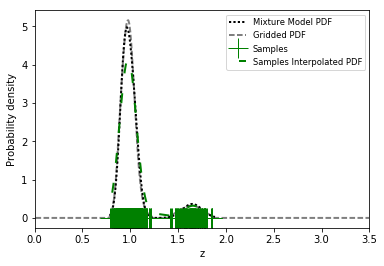

In [11]:
high_res = 1000

start_time = timeit.default_timer()
G.sample(high_res, vb=False)
G.mix_mod_fit(n_components=dataset_info[dataset_key]['N_GMM'], 
                       using='samples', vb=True)
time = timeit.default_timer() - start_time
print(str(time)+' for GMM fit to samples')

G.plot()

The `qp.composite` object can be used as the `qp.PDF.truth` to initialize a new `qp.PDF` object that doesn't have any information about the gridded or sample approximations but has a qualitatively similar shape and is thus "realistically complex" enough to draw conclusions about real data.  Now we can approximate it any way we like!  Consider this example for $N_f=20$ parameters.

Plotted truth.
Creating a `linear` interpolator for the quantiles parametrization.
interpolating between 0.870277338521 and 1.6467841075
Plotted quantiles.
Creating a `linear` interpolator for the histogram parametrization.
interpolating between 0.870277338521 and 1.68560944595
Plotted histogram.
Creating a `linear` interpolator for the samples parametrization.
interpolator support between 0.828027858785 and 1.13445865731 with extrapolation of 2.22044604925e-16
interpolating between 0.828027858785 and 1.13445865731
Plotted samples


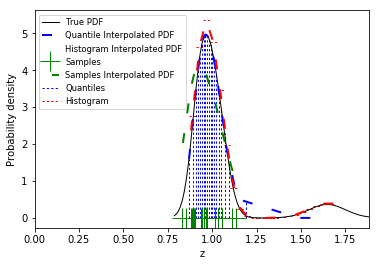

In [12]:
N_f = 20

M = qp.PDF(truth=G.mix_mod)
M.quantize(N=N_f, vb=False)
M.histogramize(N=N_f, vb=False)
M.sample(N=N_f,vb=False)
M.plot(loc=dataset_key+'_example_pz.png', vb=True)

## Quantifying the Accuracy of the Approximation

We can also calculate the KLD metric on this `qp.PDF`.  The KLD quantifies the information loss of an approximation of a PDF relative to the true PDF in units of nats.  Thus, a lower KLD corresponds to more information being preserved in the approximation.

In [13]:
formats = ['quantiles', 'histogram', 'samples']
parametrizations = {}
for f in formats:
    parametrizations[f] = {}
    for ff in formats:
        parametrizations[f][ff] = None
parametrizations['quantiles']['quantiles'] = M.quantiles
parametrizations['histogram']['histogram'] = M.histogram
parametrizations['samples']['samples'] = M.samples

dataset_info[dataset_key]['inits'] = parametrizations

klds = {}
P = qp.PDF(truth=M.truth)
for f in formats:
    Q = qp.PDF(quantiles=dataset_info[dataset_key]['inits'][f]['quantiles'], 
                histogram=dataset_info[dataset_key]['inits'][f]['histogram'], 
                samples=dataset_info[dataset_key]['inits'][f]['samples'])
    klds[f] = make_kld(P, Q)

print(klds)

Evaluating the true distribution.
Evaluating a `linear` interpolation of the quantiles parametrization.
Creating a `linear` interpolator for the quantiles parametrization.
interpolating between -10.0 and 10.0
Evaluating the true distribution.
Evaluating a `linear` interpolation of the histogram parametrization.
Creating a `linear` interpolator for the histogram parametrization.
interpolating between -10.0 and 10.0
Evaluating the true distribution.
Evaluating a `linear` interpolation of the samples parametrization.
Creating a `linear` interpolator for the samples parametrization.
interpolator support between 0.828027858785 and 1.13445865731 with extrapolation of 2.22044604925e-16
interpolating between -10.0 and 10.0
{'quantiles': 3.0633711182719714, 'samples': 3.5058520356506069, 'histogram': 2.0295610129564037}


## Survey Mode

We want to compare parametrizations for large catalogs, so we'll need to be more efficient.  The `qp.Ensemble` object is a wrapper for `qp.PDF` objects enabling conversions to be performed and metrics to be calculated in parallel.

We'll start by reading in our catalog of gridded PDFs, sampling them, fitting GMMs to the samples, and establishing a new `qp.Ensemble` object where each meber `qp.PDF` object has `qp.PDF.truth`$\neq$`None`.

In [14]:
def setup_from_grid(in_pdfs, z_grid, N_comps, high_res=1000):
    
    #read in the data, happens to be gridded
    zlim = (min(z_grid), max(z_grid))
    N_pdfs = len(in_pdfs)
    print(N_pdfs)
    
    print('making the initial ensemble')
    E0 = qp.Ensemble(N_pdfs, gridded=(z_grid, in_pdfs), vb=False)
    print('made the initial ensemble')
    
    #fit GMMs to gridded pdfs based on samples (faster than fitting to gridded)
    print('sampling for the GMM fit')
    samparr = E0.sample(high_res, vb=False)
    Ei = qp.Ensemble(N_pdfs, samples=samparr, vb=False)
    print('fitting the gmm to samples')
    GMMs = Ei.mix_mod_fit(comps=N_comps, vb=False)
    print('fit the gmm')
    
    #set the GMMS as the truth
    print('making the final ensemble')
    Ef = qp.Ensemble(N_pdfs, truth=GMMs, vb=False)
    print('made the final ensemble')
    
    return(Ef)

Next, we compute the KLD between each approximation and the truth for every member of the ensemble.  We make the `qp.Ensemble.kld` into a `qp.PDF` object of its own to compare the moments of the KLD distributions for different parametrizations.

In [15]:
def analyze_individual(E, z_grid, N_floats, N_moments=6):
    zlim = (min(z_grid), max(z_grid))
    z_range = zlim[-1] - zlim[0]
    delta_z = z_range / len(z_grid)
    
    print('making the approximate ensembles')
    Eq, Eh, Es = E, E, E
    inits = {}
    for f in formats:
        inits[f] = {}
        for ff in formats:
            inits[f][ff] = None
    inits['quantiles']['quantiles'] = Eq.quantize(N=N_floats, vb=False)
    inits['histogram']['histogram'] = Eh.histogramize(N=N_floats, vb=False)
    inits['samples']['samples'] = Es.sample(samps=N_floats, vb=False)
        
    Eo ={}
    for f in formats:
        Eo[f] = qp.Ensemble(E.n_pdfs, truth=E.truth, 
                            quantiles=inits[f]['quantiles'], 
                            histogram=inits[f]['histogram'],
                            samples=inits[f]['samples'])
    print('made the approximate ensembles')
    
    print('calculating the individual metrics')
    klds = {}
    metrics = {}
    moments = {}
    
    for key in Eo.keys():
        print('starting '+key)
        klds[key] = Eo[key].kld(using=key, limits=zlim, dx=delta_z)
        samp_metric = qp.PDF(samples=klds[key])
        gmm_metric = samp_metric.mix_mod_fit(n_components=dataset_info[dataset_key]['N_GMM'], 
                                             using='samples')
        metrics[key] = qp.PDF(truth=gmm_metric)
        moments[key] = []
        for n in range(N_moments+1):
            moments[key].append(qp.utils.calculate_moment(metrics[key], n,
                                                          using=key, 
                                                          limits=zlim, 
                                                          dx=delta_z, 
                                                          vb=False))
        print('finished with '+key)
    print('calculated the individual metrics')
    
    plot_individual(klds, N_floats)
    
    return(Eo, klds, moments)

def plot_individual(pz_klds, N_floats):
    colors = {'quantiles':'b', 'histogram':'r', 'samples':'g'}
    plot_bins = np.linspace(-3., 3., 20)
    for key in pz_klds.keys():
        plt.hist(np.log(pz_klds[key]), color=colors[key], alpha=0.5, 
             label=key, normed=True, bins=plot_bins)
    plt.legend()
    plt.ylabel('frequency')
    plt.xlabel(r'$\log[KLD]$')
    plt.title(dataset_key+r' dataset with $N_{f}='+str(N_floats)+r'$')
    plt.savefig('metric_histogram_placeholder.png', dpi=250)

Finally, we calculate metrics on the stacked estimator $\hat{n}(z)$ that is the average of all members of the ensemble.

In [ ]:
def analyze_stacked(E0, E, z_grid):
    
    zlim = (min(z_grid), max(z_grid))
    z_range = zlim[-1] - zlim[0]
    delta_z = z_range / len(z_grid)
    
    parametrizations = E.keys()
    print('stacking the ensembles')           
    stacked_pdfs = {}
    for key in formats:
        stacked_pdfs[key] = qp.PDF(gridded=E[key].stack(z, using=key, 
                                                        vb=False)[key])
    
    stacked_pdfs['truth'] = qp.PDF(gridded=E0.stack(z, using='truth', 
                                                    vb=False)['truth'])
    print('stacked the ensembles')
    
    print('calculating the metrics')
    klds = {}
    for key in parametrizations:
        klds[key] = qp.utils.calculate_kl_divergence(stacked_pdfs['truth'],
                                                     stacked_pdfs[key], 
                                                     limits=zlim, dx=delta_z)
    print('calculated the metrics')    
    
    return(stacked_pdfs, klds)

Let's run this procedure for a small subsample of the catalog.

In [ ]:
# this is a test of the experimental qp.Ensemble object!

n_gals_tot = len(pdfs)
n_gals_use = 100
full_gal_range = range(n_gals_tot)
subset = np.random.choice(full_gal_range, n_gals_use)
pdfs_use = pdfs[subset]

# using the same grid for output as the native format, but doesn't need to be so
new_z_grid = dataset_info[dataset_key]['z_grid']
dataset_info[dataset_key]['in_z_grid'] = dataset_info[dataset_key]['z_grid']
dataset_info[dataset_key]['out_z_grid'] = new_z_grid
n_floats_use = N_f

fit_components = dataset_info[dataset_key]['N_GMM']
n_moments_use = 6

pr = cProfile.Profile()
pr.enable()

catalog = setup_from_grid(pdfs_use, dataset_info[dataset_key]['z_grid'], 
                          fit_components)
(ensembles, pz_klds, metric_moments) = analyze_individual(catalog, 
                                                          new_z_grid, 
                                                          n_floats_use, 
                                                          n_moments_use)
dataset_info[dataset_key]['pz_klds'] = pz_klds
dataset_info[dataset_key]['pz_kld_moments'] = metric_moments
(stack_evals, nz_klds) = analyze_stacked(catalog, ensembles, new_z_grid)
dataset_info[dataset_key]['nz_ests'] = stack_evals
dataset_info[dataset_key]['nz_klds'] = nz_klds

pr.disable()
s = StringIO.StringIO()
sortby = 'cumtime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

with open('metadata.hkl', 'w') as result_file: 
    hickle.dump(dataset_info, result_file)

making the initial ensemble


## Scaling

We'd like to do this for many values of $N_{f}$ as well as larger catalog subsamples, repeating the analysis many times to establish error bars on the KLD as a function of format, $N_{f}$, and dataset.

In [ ]:
with open('metadata.hkl', 'r') as result_file: 
    dataset_info = hickle.load(result_file)
    
# make the plots here with data from many runs

We want to plot the moments of the KLD distribution for each format as $N_{f}$ changes.

In [ ]:
# this plot isn't really working yet and also doesn't make sense without

# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)

colors = {'quantiles':'b', 'histogram':'r', 'samples':'g'}
shapes = ['o','+','x','v','^','<','>']
fig, ax = plt.subplots()

for key in metric_moments.keys():
    ax.plot([-1], [0], color=colors[key], label=key)
ax_n = ax
for n in range(n_moments_use + 1):
    ax_n = ax_n.twinx()
    ax.scatter([-1], [0], color='k', marker=shapes[n], label=str(n))
    for key in metric_moments.keys():
        ax_n.scatter([n_floats_use], [metric_moments[key][n]], marker=shapes[n], color=colors[key])
    ax_n.set_ylabel('moment '+str(n))
    if n<3:
        ax_n.spines["right"].set_position(("axes", -0.1 * n))
    else:
        ax_n.spines["left"].set_position(("axes", 0.1 * (n-3)))
#     make_patch_spines_invisible(ax_n)
#     if n<3:
#         ax_n.spines["left"].set_visible(True)
#     else:
#         ax_n.spines["right"].set_visible(True)
    ax_n.semilogy()
ax.set_xlim(0,10)#should be N_f range and logged
ax.set_xlabel('number of parameters')
ax.legend()
fig.suptitle('moments of the KLD distribution')
# use http://matplotlib.org/examples/axes_grid/demo_parasite_axes2.html
print(metric_moments)

We also want to plt the KLD on $\hat{n}(z)$ for all formats as $N_{f}$ changes.  We want to repeat this for many subsamples of the catalog to establush error bars on the KLD values.

In [ ]:
# need to get some version of this working from nz_klds
plt.figure(figsize=(12, 5))
plt.title(r'KLD for $n(z)$')
plt.xlabel('number of parameters')
plt.ylabel('KLD')

for key in nz_klds.keys():
    # will be regular plot not scatter with more N_f options
    plt.scatter([n_floats_use], [nz_klds[key]], color=colors[key], label=key)

plt.semilogy()
plt.semilogx()
plt.legend()
plt.savefig(dataset_key+'_nz_placeholder.png')

# Everything after here is scratch.  That's all, folks!

In [ ]:
## everything works above here!  now it's time to make plots from this output!

In [ ]:
# # Function to test the experimental qp.Ensemble object!

# def analyze():#(pdfs, N_comps, z, N_floats):
    
#     #read in the data, happens to be gridded
#     z_low, z_high = min(z), max(z)
#     N_pdfs = len(pdfs)
#     out_E = {}
#     E0 = qp.Ensemble(N_pdfs, gridded=(z, pdfs), vb=False)

#     #fit gridded pdfs as GMMs based on samples
#     samparr = E0.sample(1000, vb=False)
#     print(np.shape(samparr))
#     Ei = qp.Ensemble(N_pdfs, samples=samparr, vb=False)
#     GMMs = Ei.mix_mod_fit(comps=N_comps, using='samples', vb=False)
# #     out_E['GMMs'] = []
# #     for GMM in GMMs:
# #         out_E['GMMs'].append(GMM.functions[0].stats())
    
#     #set the GMMS as the truth
#     Ef = qp.Ensemble(N_pdfs, truth=GMMs, vb=False)
    
#     #stack them and save the output
#     out_E['truth'] = Ef.stack(z, using='mix_mod', vb=False)
    
# #     #evaluate as gridded and save the output
# #     Et = qp.Ensemble(N_pdfs, gridded=Ef.evaluate(z))
# #     out_E['gridded'] = Et.stack(z, using='gridded')
    
#     #evaluate as quantiles and save the output
#     Eq = qp.Ensemble(N_pdfs, quantiles=Ef.quantize(N=N_floats), vb=False)
#     #q_stack = Eq.stack(z, using='quantiles')
#     out_E['quantiles'] = Eq.stack(z, using='quantiles', vb=False)
    
# #     #evaluate as histogram and save the output
# #     Eh = qp.Ensemble(N_pdfs, histogram=Ef.histogramize(N=N_floats, binrange=(z_low, z_high)))
# #     #h_stack = Eh.stack(z, using='histogram')
# #     out_E['histogram'] = Eh.stack(z, using='histogram')
    
# #     #evaluate as samples and save the output
# #     Es = qp.Ensemble(N_pdfs, samples=Ef.sample(samps=N_floats))
# #     #s_stack = Es.stack(z, using='samples')
# #     out_E['samples'] = Es.stack(z, using='samples')
    
#     return(out_E)#, KLDs, RMSEs)

Let's run a test with 100 galaxies and 10 parameters. This should take about 5 minutes or so.

In [ ]:
# print(n_gals_use, n_floats_use, s.getvalue())

Let's show the stacked versions and compute metrics.

In [ ]:
# print(results.keys())
# print(results['truth']['mix_mod'])

In [ ]:
# KLDs, RMSEs = {}, {}

# P = qp.PDF(gridded=results['truth']['mix_mod'])
# metric_keys = results.keys()
# metric_keys.remove('truth')

# for est in metric_keys:
#     Q = qp.PDF(gridded=results[est][est])
#     KLDs[est] = qp.utils.calculate_kl_divergence(P, Q, vb=False)
#     RMSEs[est] = qp.utils.calculate_rmse(P, Q, vb=False)
#     plt.plot(results[est][est][0], results[est][est][1], label=est)
# plt.legend()
# print(KLDs, RMSEs)

Things are quite broken after this point!

In [ ]:
# P = qp.PDF(gridded=stack_ests['truth'])

# KLDs, RMSEs = {}, {}
# for est in .keys():
#     Q = qp.PDF(gridded=stack_ests[est])
#     KLDs[est] = qp.utils.calculate_kl_divergence(P, Q, vb=False)
#     RMSEs[est] = qp.utils.calculate_rmse(P, Q, vb=False)

Let's plot the log standard deviations of the first component of the mixture models.

In [ ]:
# moments = np.array(results['stats']).T
# fit_stats = moments[1]
# plt.hist(np.log(fit_stats))

Let's check the distribution of standard deviations of the ensemble.

In [ ]:
# D = qp.PDF(samples = np.log(fit_stats))
# T = D.mix_mod_fit(n_components=1)
# D.plot()
# print(np.exp(T.functions[0].stats()))

Now enough of the `qp.Ensemble` functionality has been implemented to merge into the `master` branch!

In [ ]:
# this ends the test of the experimental qp.Ensemble object
# you may now return to your regularly scheduled programming

In [ ]:
# def analyze_one(index, N_comps, z, N_floats, logfilename='logfile.txt', vb=False):
#     """
#     Model the input BPZ P(z) as a GMM, approximate that GMM in 
#     various ways, and assess the quality of each approximation.
    
#     Parameters
#     ----------
#     index : int
#         ID of galaxy
#     N_comps : int
#         Number of components used in GMM
#     N_floats : int
#         Number of floats used to parametrize the P(z)
#     z : float, ndarr
#         Redshift array for input gridded "truth". Used for 
#         evaluating n(z) too
#     logfilename: string
#         where to put logging information
#     vb : boolean
#         Verbose output?

#     Returns
#     -------
#     result : dict
#         Dictionary containing metric values, n(z) on standard 
#         grid, samples, "true" GMM gridded p(z).
        
#     Notes
#     -----
#     In some cases the GMM does not fit well, leading to bad KLD and 
#     RMSE values when it is compared to the truth.
    
#     """
# #     # Make z array if we don't already have it:
# #     if z is None:
# #         z = np.arange(0.01, 3.51, 0.01, dtype='float')
#     dz = (max(z) - min(z)) / len(z)
#     zlimits = [min(z), max(z)]

#     # Make a dictionary to contain the results:     
#     result = {}
    
#     # Make a GMM model of the input BPZ p(z) (which are stored
#     # in the global 'pdfs' variable:
#     G = qp.PDF(gridded=(z, pdfs[index]), vb=vb)
    
#     # Draw 1000 samples, fit a GMM model to them, and make a true PDF:
#     G.sample(1000, vb=vb)
#     GMM = G.mix_mod_fit(n_components=N_comps, vb=vb)
#     P = qp.PDF(truth=GMM, vb=vb)
    
#     # Evaluate the GMM on the z grid, and store in the result dictionary. We'll 
#     # need this to make our "true" n(z) estimator. We don't need to keep the 
#     # z array, as we passed that in.
#     result['truth'] = P.evaluate(z, using='truth', vb=vb)[1]

#     # Now approximate P in various ways, and assess:
#     Q, KLD, RMSE, approximation = {}, {}, {}, {}
#     Q['quantiles'] = qp.PDF(quantiles=P.quantize(N=N_floats, vb=vb), vb=vb)
#     Q['histogram'] = qp.PDF(histogram=P.histogramize(N=N_floats, binrange=zlimits, vb=vb), vb=vb)
#     Q['samples'] = qp.PDF(samples=P.sample(N=N_floats, vb=vb), vb=vb)
#     for k in Q.keys():
#         KLD[k] = qp.calculate_kl_divergence(P, Q[k], limits=zlimits, dx=dz, vb=vb)
#         RMSE[k] = qp.calculate_rmse(P, Q[k], limits=zlimits, dx=dz, vb=vb)
#         approximation[k] = Q[k].evaluate(z, using=k, vb=vb)[1]
        
#     # Store approximations:
#     result['KLD'] = KLD
#     result['RMSE'] = RMSE
#     result['approximation'] = approximation
#     result['samples'] = Q['samples'].samples
    
#     with open(logfilename, 'a') as logfile:
#         logfile.write(str((index, timeit.default_timer() - start_time))+'\n')
    
#     return result

OK, now lets's collate the metrics for the first 100 galaxies over a variable number of parameters, and look at the distribution of metric values.  We're using multiprocessing because the `for` loop is slow; the rate-limiting step is the optimization routine for finding quantiles of a GMM.

In [ ]:
# def one_analysis(N):
    
#     all_results[str(N)] = []
    
#     pr = cProfile.Profile()
#     pr.enable()
    
# # with qp.Ensemble
#     n_gals_tot = len(pdfs)
#     full_gal_range = range(n_gals_tot)
#     subset = np.random.choice(full_gal_range, n_gals)
#     pdfs_use = pdfs[subset]
#     all_results[str(N)] = analyze(pdfs_use, nc_needed, z, N)

# # # if multiprocessing:
# #     logfilename = dataname + str(n_gals) + 'multi' + str(N)+'.txt'
# #     def help_analyze(i):
# #         return analyze_one(i, nc_needed, z, N, logfilename=logfilename)
# #     pool = Pool(psutil.cpu_count() - 1)
# #     results = pool.map(help_analyze, range(n_gals))
# #     all_results[str(N)] = results
# # # tl;dr Tmax=270s for N_floats=3, 100 galaxies, 3 processors
    
# # # if looping:
# #     logfilename = dataname + str(n_gals) + 'loop' + str(N)+'.txt'
# #     for i in range(100):
# #         all_results[str(N)].append(analyze_one(i, 2, z, N, logfilename=logfilename))
# #         if i%10 == 0: print('.', end='')
# # # tl;dr Tmax=352s for N_floats=3, 100 galaxies
    
#     pr.disable()
#     s = StringIO.StringIO()
#     sortby = 'cumtime'
#     ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
#     ps.print_stats()
#     print(N, s.getvalue())
    
#     return

In [ ]:
# #%%time

# float_numbers = [3]#, 10, 30, 100]
# n_float_numbers = len(float_numbers)

# # gal_numbers = [100]#, 1000, 10000]
# # n_gal_numbers = len(gal_numbers)

# # total_results ={}
# # for M in gal_numbers:
# #     n_gals = M
# n_gals = 100
# all_results = {}
# for N in float_numbers:
#     start_time = timeit.default_timer()
#     one_analysis(N)
# #     total_results[str(n_gals)] = all_results

Since the previous step is quite slow (on the order of 5 minutes per test of different numbers of parameters for my laptop), this is a good point to save the results.  We can load them from the file later and not remake them if we only want to do the rest of the analysis.

In [ ]:
# with open('all_results.hkl', 'w') as result_file: 
#     hickle.dump(all_results, result_file)

In [ ]:
# with open('all_results.hkl', 'r') as result_file: 
#     all_results = hickle.load(result_file)

In [ ]:
# all_results = total_results[str(gal_numbers[0])]

# all_KLD, all_RMSE = [], []
# for n in range(n_float_numbers):
#     KLD, RMSE = {}, {}
#     for approximation in all_results[str(float_numbers[n])][0]['KLD'].keys():
#         x = np.array([])
#         for k in range(len(all_results[str(float_numbers[n])])):
#             x = np.append(x, all_results[str(float_numbers[n])][k]['KLD'][approximation])
#         KLD[approximation] = x
#         x = np.array([])
#         for k in range(len(all_results[str(float_numbers[n])])):
#             x = np.append(x, all_results[str(float_numbers[n])][k]['RMSE'][approximation])
#         RMSE[approximation] = x
#     all_KLD.append(KLD)
#     all_RMSE.append(RMSE)

Now let's plot histograms of the metric values.

In [ ]:
# colors = {'samples':'green', 'quantiles':'blue', 'histogram':'red'}
# plt.figure(figsize=(12, 5 * n_float_numbers))

# i=0
# for n in range(n_float_numbers):
#     i += 1
#     # Lefthand panel: KLD
#     plt.subplot(n_float_numbers, 2, i)
#     plt.title('KLD for '+str(float_numbers[n])+' stored numbers')
#     bins = np.linspace(0.0, 5., 25)
#     for k in ['samples', 'quantiles', 'histogram']:
#         plt.hist(all_KLD[n][k], bins, label=k, fc=colors[k], ec=colors[k], alpha=0.3, normed=True)
#     #plt.semilogx()
#     plt.xlabel('KL Divergence Metric', fontsize=16)
#     plt.ylim(0., 5.0)
#     plt.xlim(0., 5.0)
#     plt.legend()
    
#     i += 1
#     # Righthand panel: RMSE
#     plt.subplot(n_float_numbers, 2, i)#+n_numbers)
#     plt.title('RMSE for '+str(float_numbers[n])+' stored numbers')
#     bins = np.linspace(0.0, 5., 25)
#     for k in ['samples', 'quantiles', 'histogram']:
#         plt.hist(all_RMSE[n][k], bins, label=k, fc=colors[k], ec=colors[k], alpha=0.3, normed=True)
#     #plt.semilogx()
#     plt.xlabel('RMS Error Metric', fontsize=16)
#     plt.ylim(0., 5.0)
#     plt.xlim(0., 5.0)
#     plt.legend();
    
# plt.savefig('money.png')

Interestingly, the metrics don't agree, nor is the behavior consistent across different numbers of parameters.  However, as the number of parameters increases, the distribution of the metrics converge to lower numbers.

KLD seems to flag more "bad" approximations than RMSE. How do we know where to set the threshold in each metric? 

We should think of the right way to get a summary statistic (first moment?) on the ensemble of KLD or RMSE values so we can make the plot of number of parameters vs. quality of approximation.

Now lets compute the estimated $n(z)$. We'll do this with the GMM "truth", and then using each of our approximations. And we'll normalize the $n(z)$ to account for lost systems with bad approximations.

In [ ]:
# plt.figure(figsize=(6, 5 * n_float_numbers))
# all_n = []
# all_x = []
# all_y = []

# for i in range(n_float_numbers):
#     results = all_results[str(float_numbers[i])]
#     n = {}

#     # Pull out all truths and compute the average at each z:
#     x = np.zeros([len(z), len(results)])
#     y = {}
#     for approx in ['samples', 'quantiles', 'histogram']:
#         y[approx] = np.zeros([len(z), len(results)])
#         for k in range(len(results)):
#             y[approx][:,k] = results[k]['approximation'][approx] 
#     for k in range(len(results)):
#         x[:,k] = results[k]['truth'] 

#     # Now do the averaging to make the estimators:
#     n['truth'] = np.mean(x, axis=1)
#     n['truth'] /= np.sum(n['truth']) * delta_z
#     for approx in ['samples', 'quantiles', 'histogram']:
#         n[approx] = np.mean(y[approx], axis=1)
#         n[approx] /= np.sum(n[approx]) * delta_z
        
#     all_n.append(n)
#     all_x.append(x)
#     all_y.append(y)

#     # Note: this uses the samples' KDE to make the approximation. We could (and 
#     # should!) also try simply concatenating the samples and histogramming them.
    
#     # Plot truth and all the approximations. 
#     # The NaNs in the histogram approximation make that unplottable for now.
#     plt.subplot(n_float_numbers, 1, i+1)#+n_numbers)
#     plt.title(r'$n(z)$ for '+str(float_numbers[i])+' numbers')
#     plt.plot(z, n['truth'], color='black', lw=4, alpha=0.3, label='truth')
#     for k in ['samples', 'quantiles', 'histogram']:
#         plt.plot(z, n[k], label=k, color=colors[k])
#     plt.xlabel('redshift z')
#     plt.ylabel('n(z)')
#     plt.legend();
# plt.savefig('nz_comparison.png', dpi=300)

The "samples" approximation gives the best result for the $n(z)$ estimator even with a small number of samples.  However, once the number of parameters increases slightly, the "quantiles" approximation performs similarly.  It takes a large number of parameters before the "histogram" approximation approaches the other options. Let's use the `qp.PDF` object to compare them quantitatively (since $n(z)$ can be normalized to give the global $p(z)$).

In [ ]:
# all_p = []

# for i in range(n_float_numbers):
#     n = all_n[i]
#     p = {}
#     for k in ['samples', 'quantiles', 'histogram']:
#         p[k] = qp.PDF(gridded=(z,n[k]), vb=False)

#     p['truth'] = qp.PDF(gridded=(z,n['truth']), vb=False)
    
#     all_p.append(p)

In [ ]:
# all_KLD_nz, all_RMSE_nz = {}, {}
# zlimits, dz = [z_low, z_high], 0.01
# for k in ['samples', 'quantiles', 'histogram']:
#     p = all_p[i]
#     KLD_nz, RMSE_nz = [], []
#     for i in range(n_float_numbers):
#         KLD_nz.append(qp.calculate_kl_divergence(all_p[i]['truth'], all_p[i][k], limits=zlimits, dx=dz, vb=False))
#         RMSE_nz.append(qp.calculate_rmse(all_p[i]['truth'], all_p[i][k], limits=zlimits, dx=dz, vb=False))
    
#     all_KLD_nz[k] = KLD_nz
#     all_RMSE_nz[k] = RMSE_nz

In [ ]:
# plt.figure(figsize=(12, 5))
# both = [plt.subplot(1, 2, i+1) for i in range(2)]
# KLD_plot = both[0]
# RMSE_plot = both[1]
# KLD_plot.set_title(r'KLD for $n(z)$')
# RMSE_plot.set_title(r'RMSE for $n(z)$')
# KLD_plot.set_xlabel('number of parameters')
# RMSE_plot.set_xlabel('number of parameters')
# KLD_plot.set_ylabel('KLD')
# RMSE_plot.set_ylabel('RMSE')
# # KLD_plot.semilogx()
# # KLD_plot.semilogy()
# # RMSE_plot.semilogx()
# # RMSE_plot.semilogy()

# for k in ['samples', 'quantiles', 'histogram']:
#     KLD_plot.plot(float_numbers, all_KLD_nz[k], color=colors[k], label=k)
#     RMSE_plot.plot(float_numbers, all_RMSE_nz[k], color=colors[k], label=k)

# KLD_plot.semilogy()
# KLD_plot.semilogx()
# RMSE_plot.semilogy()
# RMSE_plot.semilogx()
# KLD_plot.legend()
# RMSE_plot.legend()
# plt.savefig('summary.png')

In [ ]:
# print('KLD metrics for n(z) estimator: ', all_KLD_nz)
# print('RMSE metrics for n(z) estimator: ', all_RMSE_nz)

This early indication suggests that quantiles perform best on the cleaner data set.

A bigger test, using the full dataset, should allow this to be tested further: jack-knife error bars should also be calculable. 